<a href="https://colab.research.google.com/github/sokrypton/seqmodels/blob/master/seqmodels.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# ------------------------------------------------------------------
# "THE BEERWARE LICENSE" (Revision 42)
# ------------------------------------------------------------------
# <so@g.harvard.edu> wrote this code. As long as you retain this
# notice, you can do whatever you want with this stuff. If we meet
# someday, and you think this stuff is worth it, you can buy us a
# beer in return. --Sergey Ovchinnikov

In [2]:
%tensorflow_version 1.x
import tensorflow as tf
import numpy as np
import matplotlib.pylab as plt
from scipy.spatial.distance import squareform

TensorFlow 1.x selected.


## functions

In [3]:
def tf_cov(x,w=None):
  '''compute weighted covariance matrix'''
  # 15Oct2019 - fixing minor bug discoverd by Sirui Liu
  if w is None:
    num_points = tf.cast(tf.shape(x)[0],tf.float32)
    one = 1.0
    x_mean = tf.reduce_mean(x, axis=0, keepdims=True)
    x = (x - x_mean)
  else:
    num_points = tf.reduce_sum(w)
    one = tf.reduce_sum(tf.square(w))/num_points
    x_mean = tf.reduce_sum(x * w[:,None], axis=0, keepdims=True) / num_points
    x = (x - x_mean) * tf.sqrt(w[:,None])
  return tf.matmul(tf.transpose(x),x)/(num_points - one)

def tf_weights(x_msa, w_lam=0.8, gap_cutoff=0.5):
  '''compute weight for each sequence'''

  x_nongap = tf.cast(tf.reduce_mean(x_msa[:,:,-1],axis=0) < gap_cutoff, tf.float32)
  x_msa_nongap = x_msa * x_nongap[None,:,None]
  x_ln = tf.reduce_sum(x_nongap)
  
  x_pw = tf.tensordot(x_msa_nongap, x_msa_nongap, [[1,2], [1,2]]) / x_ln
  x_cut = tf.cast(x_pw >= w_lam, tf.float32)
  return 1.0/tf.reduce_sum(x_cut,-1)

def tf_apc(x_w):
  '''Average Product Correction'''  
  x_wi = tf.sqrt(tf.reduce_sum(tf.square(x_w[:,:20,:,:20]), axis=(1,3)) + 1e-8)
  x_wi = x_wi - tf.matrix_band_part(x_wi,0,0)
  x_ap_sum = tf.reduce_sum(x_wi,axis=0)
  x_ap = x_ap_sum[None,:] * x_ap_sum[:,None] / tf.reduce_sum(x_ap_sum)
  x_wip = (x_wi - x_ap) 
  x_wip = x_wip - tf.matrix_band_part(x_wip,0,0)
  return x_wi, x_wip

def opt_adam(loss, name, var_list=None, lr=1.0, b1=0.9, b2=0.999, b_fix=False):
  '''modified adam optimizer'''
  
  if var_list is None: var_list = tf.trainable_variables() 
  gradients = tf.gradients(loss,var_list)
  if b_fix: t = tf.Variable(0.0,"t")
  opt = []
  for n,(x,g) in enumerate(zip(var_list,gradients)):
    if g is not None:
      ini = dict(initializer=tf.zeros_initializer,trainable=False)
      mt = tf.get_variable(name+"_mt_"+str(n),shape=list(x.shape), **ini)
      vt = tf.get_variable(name+"_vt_"+str(n),shape=[], **ini)
      
      mt_tmp = b1*mt+(1-b1)*g
      vt_tmp = b2*vt+(1-b2)*tf.reduce_sum(tf.square(g))
      lr_tmp = lr/(tf.sqrt(vt_tmp) + 1e-8)

      if b_fix: lr_tmp = lr_tmp * tf.sqrt(1-tf.pow(b2,t))/(1-tf.pow(b1,t))

      opt.append(x.assign_add(-lr_tmp * mt_tmp))
      opt.append(vt.assign(vt_tmp))
      opt.append(mt.assign(mt_tmp))
        
  if b_fix: opt.append(t.assign_add(1.0))
  return(tf.group(opt))

## INV_COV

In [4]:
def INV_COV(X=None, W=None,
            lam_w=4.5, pcc=False,
            rm_diag=False, weights_pc=True):
  
  ##############################################################################################
  def inv_cov_model():
    # input msa
    x = tf.placeholder(tf.uint8,shape=(None,None),name="x")

    x_shape = tf.shape(x)
    x_nr = x_shape[0] # num rows
    x_nc = x_shape[1] # num cols
    cat = 21
    x_msa = tf.one_hot(x,cat) # one-hot encode msa
    x_feat = tf.reshape(x_msa,(x_nr, x_nc * cat))

    if weights_pc:
      # load precomputed weights for each sequence
      x_weights = tf.placeholder(tf.float32,shape=(None,),name="x_weights") 
    else:
      x_weights = tf_weights(x_msa)

    # compute covariance
    x_c = tf_cov(x_feat,x_weights)

    # add reg
    x_reg_alpha = lam_w/tf.sqrt(tf.reduce_sum(x_weights))
    x_I = tf.eye(x_nc * cat)
    x_c = x_c + x_reg_alpha * x_I

    # compute inverse
    x_c_inv = tf.linalg.inv(x_c)

    if pcc:
      # partial correlation coefficient
      x_c_inv_diag = tf.diag_part(x_c_inv)
      x_w = x_c_inv / tf.sqrt(x_c_inv_diag[None,:] * x_c_inv_diag[:,None])
    elif rm_diag:
      # zero-out diag
      x_w = x_c_inv / tf.diag_part(x_c_inv) - x_I
      x_w = (x_w + tf.transpose(x_w))/2
    else:
      x_w = x_c_inv

    # do apc
    x_w = tf.reshape(x_w,shape=(x_nc,cat,x_nc,cat))
    x_wi, x_wip = tf_apc(x_w)

    return x_wip, x, x_weights
  ##############################################################################################

  if X is None:
    return inv_cov_model()
  else:
    tf.reset_default_graph()
    pred, x, w = inv_cov_model()
    with tf.Session() as sess:
      return sess.run(pred,{x:X,w:W})

## MSE

In [5]:
def MSE(X,W=None,
        opt_rate=1.0,
        opt_iter=100,
        lam_w=4.5,
        rm_diag=False,
        verbose=False,
        use_bias=True):
  
  def L2(x, axis=None):
    return tf.reduce_sum(tf.square(x),axis=axis)
  
  tf.reset_default_graph()
  ln = X.shape[1]
  fs = ln * 21
  
  x = tf.constant(X,tf.uint8)
  x = tf.one_hot(x,21)
  
  # if weights are not provided, compute them
  if W is None: x_weights = tf_weights(x)
  else: x_weights = tf.constant(W,tf.float32)
  
  x_true = tf.reshape(x,(-1,fs))  
  x_mean = tf.reduce_sum(x_true*x_weights[:,None],axis=0,keepdims=True)/tf.reduce_sum(x_weights)
  
  w = tf.get_variable("w",shape=(fs,fs),initializer=tf.zeros_initializer)
  w = w + tf.transpose(w)
  
  if rm_diag: w = w - tf.matrix_band_part(w,0,0)
  
  if use_bias:
    x_pred = tf.tensordot(x_true - x_mean, w, 1) + x_mean
  else:
    x_pred = tf.tensordot(x_true, w, 1)
    
  loss = tf.reduce_sum(L2(x_true-x_pred,-1) * x_weights) / tf.reduce_sum(x_weights)
  loss = loss - 2.0 * tf.trace(w)

  if lam_w > 0:
    loss_reg = (lam_w/tf.sqrt(tf.reduce_sum(x_weights))) * L2(w)
    loss = loss + loss_reg    
  
  opt = opt_adam(loss,"opt",lr=opt_rate)

  # do_apc
  x_w = tf.reshape(w,(ln,21,ln,21))
  x_wi, x_wip = tf_apc(x_w)  

  with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for k in range(opt_iter):
      sess.run(opt)
      if verbose and (k+1) % int(opt_iter/10) == 0:
        print((k+1),sess.run(loss))
    return sess.run(x_wip)

## CCE
this function is based on GREMLIN_TF, for full version see:

https://github.com/sokrypton/GREMLIN_CPP/blob/master/GREMLIN_TF_v2_BETA.ipynb

In [6]:
def CCE(msa,
        msa_weights=None,
        opt_rate=1.0,
        opt_iter=100,
        use_bias=True,
        lam_w=0.01,
        lam_b=0.01,
        ignore_gap=False,
        verbose=False):

  # collecting some information about input msa
  nrow = msa.shape[0] # number of sequences
  ncol = msa.shape[1] # length of sequence
  if ignore_gap:
    ncat = 20
  else:
    ncat = 21   
  
  # kill any existing tensorflow graph
  tf.reset_default_graph()

  # setting up weights
  if use_bias:
    b = tf.get_variable("b", [ncol,ncat],
                        initializer=tf.initializers.zeros)
    
  w = tf.get_variable("w", [ncol,ncat,ncol,ncat],
                      initializer=tf.initializers.zeros)
  # symmetrize w
  w = w * np.reshape(1-np.eye(ncol),(ncol,1,ncol,1))
  w = w + tf.transpose(w,[2,3,0,1])
  
  # input
  X = tf.constant(msa,tf.uint8,name="x")
  MSA = tf.one_hot(X,21)
  
  # if weights are not provided, compute them
  if msa_weights is None:
    MSA_weights = tf_weights(MSA)
  else:
    MSA_weights = tf.constant(msa_weights,tf.float32,name="msa_weights")
  
  if ignore_gap:
    non_gap = tf.abs(1.0 - MSA[...,-1])
    MSA = MSA[...,:-1]
     
  NEFF = tf.reduce_sum(MSA_weights)

  # dense layer 
  MSA_logit = tf.tensordot(MSA,w,2)
  if use_bias:
    MSA_logit = MSA_logit + b
    
  # softmax activation
  MSA_pred = tf.nn.softmax(MSA_logit, -1)

  # loss = categorical crossentropy (aka pseudo-likelihood)
  loss = tf.keras.losses.categorical_crossentropy(MSA,MSA_pred)
  if ignore_gap:
    loss = loss * non_gap
    
  loss = tf.reduce_sum(loss, axis=-1)
  loss = tf.reduce_sum(loss * MSA_weights)

  # L2 regularization
  reg = lam_w * tf.reduce_sum(tf.square(w)) * 0.5 * (ncol-1) * 20.0 
  if use_bias:
    reg = reg + lam_b * tf.reduce_sum(tf.square(b))

  loss = (loss + reg) / NEFF
  opt = opt_adam(loss, "adam", lr=opt_rate)
  
  # do apc
  x_wi, x_wip = tf_apc(w)
    
  with tf.Session() as sess:
    sess = tf.Session()
    sess.run(tf.global_variables_initializer())

    if use_bias:
      msa_cat = np.eye(21)[msa]
      if ignore_gap:
        msa_cat = msa_cat[...,:-1]
      if msa_weights is None:
        msa_weights = sess.run(MSA_weights)
        
      pseudo_count = 0.01 * np.log(np.sum(msa_weights))
      b_ini = np.log(np.sum(msa_cat.T * msa_weights,-1).T + pseudo_count)
      b_ini = b_ini - np.mean(b_ini,-1,keepdims=True)
      sess.run(b.assign(b_ini))
    
    for k in range(opt_iter):
      sess.run(opt)
      if verbose and (k+1) % int(opt_iter/10) == 0:
        print((k+1),sess.run(loss))      
    return sess.run(x_wip)

## DATASET

In [7]:
%%bash 
wget -nc -q https://github.com/sokrypton/seqmodels/raw/master/data.pickle.npy.gz
gunzip data.pickle.npy.gz

In [8]:
data = list(np.load("data.pickle.npy",allow_pickle=True))

In [ ]:
#########################
# optional - remove positions > 50% gaps
#########################
rm_gaps = False
if rm_gaps:
  for a in data:
    gap_chk = (1 - (a["x"] == 20).mean(0)) > 0.5 
    a["x"] = a["x"][:,gap_chk]
    a["x_mask"] = a["x_mask"][gap_chk,:][:,gap_chk]
    a["x_true"] = a["x_true"][gap_chk,:][:,gap_chk]

In [ ]:
def con_auc(true, pred, mask=None, thresh=0.01):
  '''compute agreement between predicted and measured contact map'''
  if mask is not None:
    idx = mask.sum(-1) > 0
    true = true[idx,:][:,idx]
    pred = pred[idx,:][:,idx]
  eval_idx = np.triu_indices_from(true, 6)
  pred_, true_ = pred[eval_idx], true[eval_idx] 
  L = (np.linspace(0.1,1.0,10)*len(true)).astype("int")
  sort_idx = np.argsort(pred_)[::-1]
  acc = [(true_[sort_idx[:l]] > thresh).mean() for l in L]
  return np.mean(acc)

3A0YA 0.7544308264679203 0.756756407863269 0.760741866614842


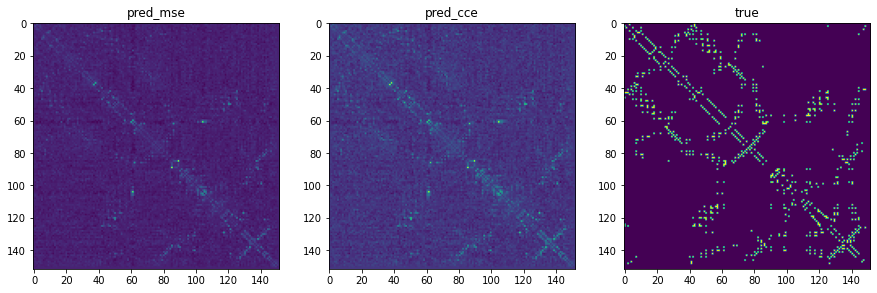

In [ ]:
for n,a in enumerate(data):  

  pred_ic = INV_COV(a["x"],a["x_w"])
  pred_mse = MSE(a["x"],a["x_w"])
  pred_cce = CCE(a["x"],a["x_w"])

  auc_ic  = con_auc(a["x_true"],pred_ic, a["x_mask"])
  auc_mse = con_auc(a["x_true"],pred_mse,a["x_mask"]) 
  auc_cce = con_auc(a["x_true"],pred_cce,a["x_mask"]) 
  print(a["x_id"],auc_ic,auc_mse,auc_cce)

  plt.figure(figsize=(15,5))
  plt.subplot(1,3,1); plt.title("pred_mse"); plt.imshow(pred_mse)
  plt.subplot(1,3,2); plt.title("pred_cce"); plt.imshow(pred_cce)
  plt.subplot(1,3,3); plt.title("true"); plt.imshow(a["x_true"] > 0.01)
  plt.show()

  if n == 0: break

## FIGURE 4

### EXTERNAL METHOD: GaussDCA

In [ ]:
%%bash
git clone https://github.com/MMichel/GaussDCA.git

Cloning into 'GaussDCA'...


In [ ]:
%%writefile GaussDCA/src/setup.py
from __future__ import division
from setuptools import setup, Extension
from Cython.Build import cythonize
import numpy
extension = Extension('_load_data', ['_load_data.pyx'],include_dirs=[numpy.get_include()],
                      extra_compile_args="-O2 -march=native -pipe -mtune=native".split(),
                      extra_link_args="-O2 -march=native -pipe -mtune=native".split())
setup(name='ss_load_data', ext_modules=cythonize(extension))
extension = Extension('_gaussdca', ['_gaussdca.pyx'],include_dirs=[numpy.get_include()],
                      extra_compile_args='-O2 -march=native -pipe -std=c11'.split(),
                      extra_link_args='-O2 -march=native -pipe -std=c11'.split())
setup(name='_gaussdca', ext_modules=cythonize(extension))
extension = Extension('_gaussdca_parallel', ['_gaussdca_parallel.pyx'],include_dirs=[numpy.get_include()],
                      extra_compile_args='-O2 -march=native -pipe -std=c11 -fopenmp'.split(),
                      extra_link_args='-O2 -march=native -pipe -std=c11 -fopenmp'.split())
setup(name='_gaussdca_parallel', ext_modules=cythonize(extension))
extension = Extension('_gaussdca_parallel_opt', ['_gaussdca_parallel_opt.pyx'],
                      include_dirs=[numpy.get_include()],
                      extra_compile_args='-O2 -march=native -pipe -std=c11 -fopenmp'.split(),
                      extra_link_args='-O2 -march=native -pipe -std=c11 -fopenmp'.split())
setup(name='_gaussdca_parallel_opt', ext_modules=cythonize(extension))

Overwriting GaussDCA/src/setup.py


In [ ]:
%%bash
cd GaussDCA/
cd src
python setup.py build_ext -i

In [ ]:
!pip -q install biopython

     |████████████████████████████████| 2.2MB 4.9MB/s 


### EXTERNAL METHOD: DI

In [ ]:
def get_di(X,W,pc=0.5,k_max=10):
  nr = X.shape[0]
  nc = X.shape[1]
  ns = 21
  na = ns-1   
  
  x = np.eye(21)[X]

  ni, nj = np.triu_indices(nc,k=1)
  nw = len(ni)

  f = np.sum(x * W[:,None,None],0) / np.sum(W)
  x_feat = np.reshape(x,(nr,nc*ns))
  x_feat = x_feat * np.sqrt(W[:,None])
  c = np.matmul(np.transpose(x_feat), x_feat)/np.sum(W)
  c = c.reshape(nc,ns,nc,ns)

  ff = c[ni,:,nj,:]
  ff_diag = c[range(nc),:,range(nc)]
  
  # add pseudocount
  if pc > 0:
    pc_i = pc / ns
    pc_ij = pc / (ns * ns)

    f = (1-pc) * f + pc_i
    ff = (1-pc) * ff + pc_ij
    ff_diag = (1-pc) * ff_diag + pc_i * np.eye(ns)

  # compute covariance matrix
  c = ff[:,:-1,:-1] - f[ni,:-1,None] * f[nj,None,:-1]
  c_diag = ff_diag[:,:-1,:-1] - f[:,:-1,None] * f[:,None,:-1]

  # make covariance matrix into square
  c_sq = np.zeros((nc,na,nc,na))
  c_sq[ni,:,nj,:] = c
  c_sq[nj,:,ni,:] = c.transpose((0,2,1))
  c_sq[range(nc),:,range(nc),:] = c_diag

  # invert covariance matrix
  c_inv = np.linalg.inv(c_sq.reshape(nc*na,nc*na)).reshape(nc,na,nc,na)[ni,:,nj,:]

  w = np.ones((nw,ns,ns))
  w[:,:-1,:-1] = np.exp(-c_inv)

  # recompute entropy (needed for di)
  h = -np.sum(f * np.log(f + 1e-8),1)

  # compute di
  di = np.empty(nw)
  for n,(i,j) in enumerate(zip(ni,nj)):

    vi = np.ones(ns)/ns
    vj = np.ones(ns)/ns
    for k in range(k_max):
      vi = f[i] / np.einsum("j,ij -> i",vj,w[n])
      vi = vi / np.sum(vi)

      vj = f[j] / np.einsum("i,ij -> j",vi,w[n])
      vj = vj / np.sum(vj)

    ff_di = w[n] * vi[:,None] * vj[None,:]
    ff_di = ff_di / np.sum(ff_di)

    di[n] = h[i] + h[j] + np.sum(ff_di * np.log(ff_di + 1e-8))

  di = squareform(di)
  ap = np.sum(di,0)
  return di - (ap[None,:] * ap[:,None]) / np.sum(ap)

### Generate data

In [ ]:
import os
os.mkdir("gDCA")
os.mkdir("DI")
os.mkdir("MSE")
os.mkdir("CCE")

In [ ]:
%%bash
# download precomputed matrices for gDCA (these are slow to generate)
wget -ncq https://github.com/sokrypton/seqmodels/raw/master/data/gDCA.tar.gz
tar -zxf gDCA.tar.gz

In [ ]:
aa_new = np.array(['A','R','N','D','C','Q','E','G','H','I','L','K','M','F','P','S','T','W','Y','V','-'])
def parse_gDCA(out,ln):
  mtx = np.loadtxt(out,np.str)
  i = mtx[:,0].astype(np.int)-1
  j = mtx[:,1].astype(np.int)-1
  v = mtx[:,2].astype(np.float)

  pred = np.zeros((ln,ln))
  pred[i,j] = v
  pred[j,i] = v
  return pred

In [ ]:
for n,a in enumerate(data):
  print(a["x_id"])
  
  out = "gDCA/"+a["x_id"]+".out"
  if os.path.isfile(out) == False:
    print(a["x_id"])
    fas = "gDCA/"+a["x_id"]+".fas"
    if os.path.isfile(fas) == False:
      file = open(fas,"w")
      for s in range(len(a["x"])):
        file.write(f">s{s}\n"+"".join(aa_new[a["x"][s]])+"\n")
      file.close()
    os.system(f"python GaussDCA/src/gaussdca.py -o {out} -s 0 {fas}")
    
    pred = parse_gDCA(out,a["x_true"].shape[0])
    np.savetxt(out,pred)
    
  out = "DI/"+a["x_id"]+".out"
  if os.path.isfile(out) == False:
    np.savetxt(out,get_di(a["x"],a["x_w"]))

  out = "MSE/"+a["x_id"]+".out"
  if os.path.isfile(out) == False:
    np.savetxt(out,INV_COV(a["x"],a["x_w"]))      

  out = "CCE/"+a["x_id"]+".out"
  if os.path.isfile(out) == False:
    np.savetxt(out,CCE(a["x"],a["x_w"],opt_iter=100)) 

### FIGURE 4

In [ ]:
# compute matrices for a few experimental runs
tf.reset_default_graph()
x_pred_1, x_1, x_w_1 = INV_COV(rm_diag=True, pcc=False)
x_pred_2, x_2, x_w_2 = INV_COV(rm_diag=False, pcc=True)

MSE_nodiag = {}
MSE_pcc = {}

with tf.Session() as sess:
  for n,a in enumerate(data):
    print(n)
    MSE_nodiag[a["x_id"]] = sess.run(x_pred_1,{x_1:a["x"],x_w_1:a["x_w"]})
    MSE_pcc[a["x_id"]]    = sess.run(x_pred_2,{x_2:a["x"],x_w_2:a["x_w"]})

In [ ]:
# compute accuracy of each method
AUC = []
for n,a in enumerate(data):
  auc = []
  for meth in ("DI","gDCA","CCE","MSE","MSE_nodiag","MSE_pcc"):
    if meth == "MSE_nodiag": pred = MSE_nodiag[a["x_id"]]
    elif meth == "MSE_pcc":  pred = MSE_pcc[a["x_id"]]
    else:
      out = meth+"/"+a["x_id"]+".out"
      pred = np.loadtxt(out)
    auc.append(con_auc(a["x_true"],pred,a["x_mask"]))
  AUC.append(auc)
AUC = np.array(AUC)

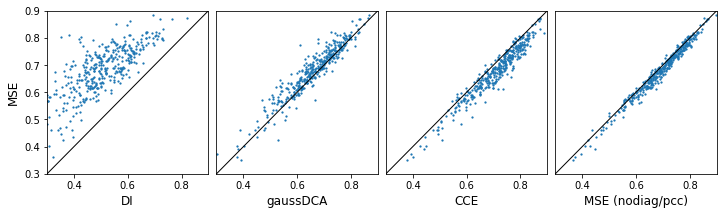

In [ ]:
plt.figure(figsize=(4*3,3))
plt.subplots_adjust(wspace=0.05, hspace=None)
a, b = 0.3,0.9
ticks = [0.4,0.6,0.8]

for n,(label,idx) in enumerate([["DI",0],["gaussDCA",1],["CCE",2],["MSE (nodiag/pcc)",4]]):
  plt.subplot(1,4,n+1)
  plt.scatter(AUC[:,idx],AUC[:,3],s=1.5);
  plt.ylim(a,b); plt.xlim(a,b)
  plt.xlabel(label,fontsize=12);
  plt.plot([0,1],[0,1],c="black",linewidth=1)
  plt.xticks(ticks)
  if n == 0:
    plt.ylabel("MSE",fontsize=12)
  else:
    plt.yticks(ticks)
    plt.gca().axes.get_yaxis().set_visible(False)

plt.savefig("unified_fig4_b.pdf",bbox_inches = "tight")

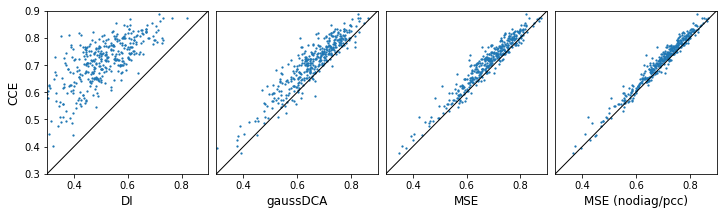

In [ ]:
plt.figure(figsize=(4*3,3))
plt.subplots_adjust(wspace=0.05, hspace=None)
a, b = 0.3,0.9
ticks = [0.4,0.6,0.8]

for n,(label,idx) in enumerate([["DI",0],["gaussDCA",1],["MSE",3],["MSE (nodiag/pcc)",4]]):
  plt.subplot(1,4,n+1)
  plt.scatter(AUC[:,idx],AUC[:,2],s=1.5);
  plt.ylim(a,b); plt.xlim(a,b)
  plt.xlabel(label,fontsize=12);
  plt.plot([0,1],[0,1],c="black",linewidth=1)
  plt.xticks(ticks)
  if n == 0:
    plt.ylabel("CCE",fontsize=12)
  else:
    plt.yticks(ticks)
    plt.gca().axes.get_yaxis().set_visible(False)

plt.savefig("unified_fig4_c.pdf",bbox_inches = "tight")

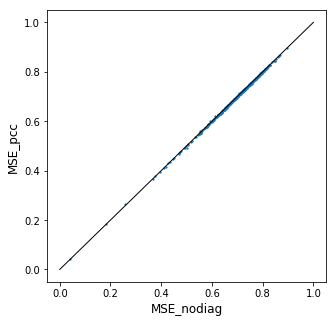

In [ ]:
plt.figure(figsize=(5,5))
plt.scatter(AUC[:,4],AUC[:,5],s=1.5);
plt.xlabel("MSE_nodiag",fontsize=12);
plt.ylabel("MSE_pcc",fontsize=12);
plt.plot([0,1],[0,1],c="black",linewidth=1)
plt.show()
